In [85]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import mysql.connector

import sys
sys.path.insert(0,"/home/apprenant/PycharmProjects/FoodFlix")


In [86]:
#keep the data
df_original = pd.read_csv("../data/02_intermediate/intermediate.csv", sep=',', low_memory=False)
df_original.columns

Index(['product_name', 'generic_name', 'brands', 'categories',
       'nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],
      dtype='object')

In [87]:
# je ne garde que les données quantitatives
int_float_df = df_original.select_dtypes(include=['int64', 'float64'])
int_float_df.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

In [88]:

columns = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g']


<AxesSubplot:>

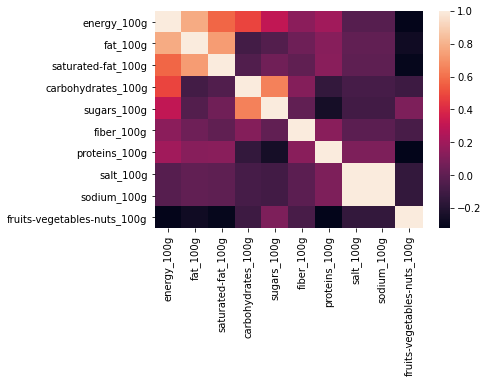

In [89]:
to_heat = int_float_df.loc[:,columns]
sns.heatmap(to_heat.corr())

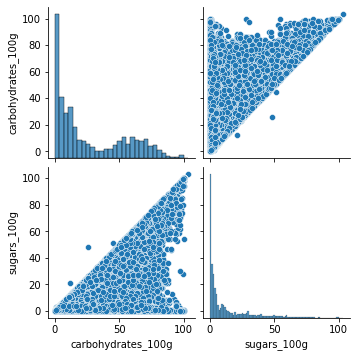

In [90]:
#corrélation entre sugar et glucide
columns3 = ['carbohydrates_100g','sugars_100g']
df_corr3 = int_float_df.loc[:,columns3]
sns.pairplot(df_corr3)
plt.show()

on constate que les glucides sont composés entre autre de sucre, ce qui fait que la teneur en sucre ne peut etre supérieure aux glucides.


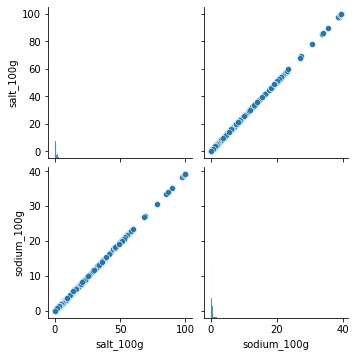

In [91]:
#corrélation entre sel et sodium
columns4 = ['salt_100g','sodium_100g']
df_corr4 = int_float_df.loc[:,columns4]
sns.pairplot(df_corr4)
plt.show()

Le sel est composé à 40% de sodium (notion métier). Cette corrélation est parfaitement visible dans le jeu de donées:pour 100g de sel on a 40g de sodium max.

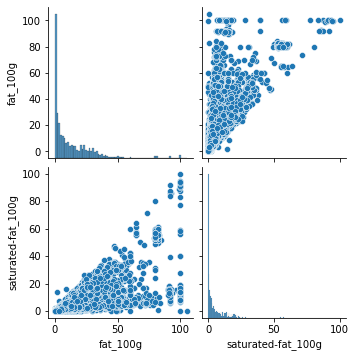

In [92]:
#corrélation entre sturedfat et fat
columns3 = ['fat_100g', 'saturated-fat_100g']
df_corr3 = int_float_df.loc[:,columns3]
sns.pairplot(df_corr3)
plt.show()

on constate que les graisses saturées sont un type de graisse, donc le niveau de graisses saturées ne peut etre supérieur aux graisses.

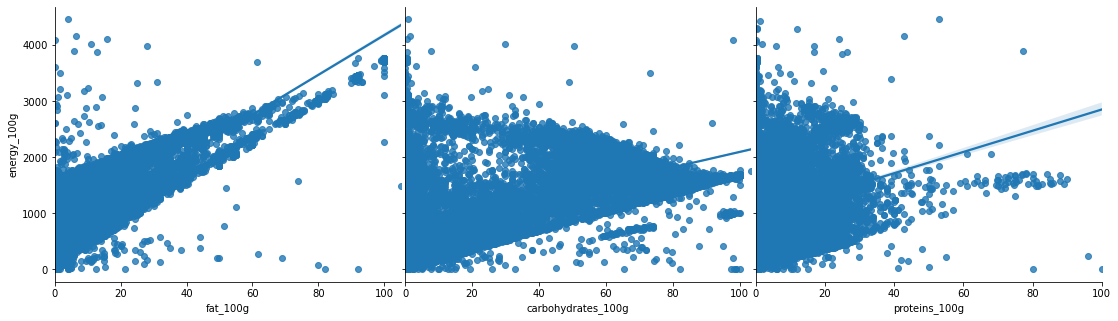

In [93]:

g = sns.PairGrid(int_float_df, y_vars=["energy_100g"], x_vars=['fat_100g', 
                                                   'carbohydrates_100g', 'proteins_100g'], height = 25)
g.map(sns.regplot)
fig=plt.gcf()
fig.set_size_inches(15,4)

# 1. Traitement des Doublons

## 2.1 recherche des doublons

In [94]:
print(df_original.duplicated().value_counts())
df_original.shape

False    29424
True        25
dtype: int64


(29449, 17)

## II.2 Traitement des doublons

In [97]:
df_original.drop_duplicates(keep='last',inplace=True)
print(df_original[df_original.duplicated(keep=False)])
df_original.shape

Empty DataFrame
Columns: [product_name, generic_name, brands, categories, nutrition_grade_fr, energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, fruits-vegetables-nuts_100g, nutrition-score-fr_100g, nutrition-score-uk_100g]
Index: []


(29424, 17)

# 2. Traitement des valeurs manquantes

In [98]:
#recherche des valeurs manquantes:

print(df_original.isna().sum())
print(df_original.shape)

product_name                       0
generic_name                   18642
brands                           314
categories                      9381
nutrition_grade_fr              5016
energy_100g                     4131
fat_100g                        8449
saturated-fat_100g              4637
carbohydrates_100g              8571
sugars_100g                     4625
fiber_100g                     12591
proteins_100g                   4186
salt_100g                       4606
sodium_100g                     4606
fruits-vegetables-nuts_100g    28577
nutrition-score-fr_100g         5016
nutrition-score-uk_100g         5016
dtype: int64
(29424, 17)


comme il s'agit ici de calculer un score, je remplace toutes les valeurs Nan par zéro.

In [99]:
df_v1 = df_original.fillna(0)

In [100]:
print(df_v1.isna().sum())
print(df_v1.shape)

product_name                   0
generic_name                   0
brands                         0
categories                     0
nutrition_grade_fr             0
energy_100g                    0
fat_100g                       0
saturated-fat_100g             0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
sodium_100g                    0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
nutrition-score-uk_100g        0
dtype: int64
(29424, 17)


on constate que les Nan ont bien été modifiées.

# 3.Consistance, reformatage et valeurs abbérantes.

## 3.1 Evaluer la consistance des variables de type caractère.

#### Afficher l'ensemble des valeurs uniques

In [101]:
df_v1["product_name"].value_counts()

Huile d'olive vierge extra          20
Orange                              18
Lait demi-écrémé                    17
Spaghetti                           17
Mayonnaise                          17
                                    ..
Tartinade de Thon                    1
3 Oeufs avec surprise                1
Zéro café Peach on the beach         1
Jambon Cuit Superieur 4 Tranches     1
Coulommiers (23% MG)                 1
Name: product_name, Length: 26339, dtype: int64

pour les produits sur-représentés il convient de vérifier quelle valeur est la bonne

certains produits ont plusieurs occurences, je vais les fusionner en une ligne dont les valeurs quantitatives seront la moyenne des précédentes.

In [102]:
#j'utilise l'exemple de la mayonnaise pour verifier mes actions
s_before = df_v1[df_v1.loc[:,'product_name']=='Mayonnaise']
s_before

,product_name,generic_name,brands,categories,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
3,Mayonnaise,0,Benedicta,0,e,3059.0,80.1,6.0,0.9,0.2,0.0,1.6,1.30,0.511811,0.0,19.0,19.0
2790,Mayonnaise,0,Délice du Nord,"Epicerie,Sauces,Mayonnaises",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
6882,Mayonnaise,0,Bouton d'Or,"Epicerie,Sauces,Mayonnaises",d,2692.0,70.7,6.0,3.2,2.4,0.0,1.1,1.08,0.425197,0.0,17.0,17.0
7746,Mayonnaise,Mayonnaise,Lesieur,"Epicerie,Sauces,Mayonnaises",d,2694.0,71.0,5.6,3.0,2.0,0.5,1.0,1.27,0.500000,0.0,18.0,18.0
9249,Mayonnaise,0,Tous Les Jours,"Epicerie,Sauces,Mayonnaises",d,2682.0,70.0,5.3,2.0,1.6,0.0,0.8,1.20,0.472441,0.0,18.0,18.0
9405,Mayonnaise,0,Bonneterre,Mayonnaises,e,2994.0,79.6,9.0,1.5,0.9,0.2,1.3,1.30,0.511811,0.0,21.0,21.0
13937,Mayonnaise,0,Delouis fils,"Epicerie,Sauces,Mayonnaises",e,3063.0,0.0,9.3,0.0,0.0,0.0,2.2,1.60,0.629921,0.0,24.0,24.0
16990,Mayonnaise,Mayonnaise,Lesieur,"Epicerie,Sauces,Mayonnaises",d,2707.0,71.0,5.4,2.8,2.1,0.0,1.0,1.27,0.500000,0.0,18.0,18.0
18751,Mayonnaise,0,Hema,0,e,3038.0,0.0,6.2,0.0,4.2,0.2,1.4,1.75,0.688976,0.0,22.0,22.0
19029,Mayonnaise,0,Carrefour,en:fats,d,2778.0,72.0,6.0,1.9,1.2,0.0,1.4,1.50,0.590551,0.0,14.0,19.0


In [103]:
df_v2 = df_v1.groupby('product_name').agg({'product_name':'first',
                                      'generic_name':'first',
                                      'brands':'first',
                                      'categories':'first',                                    
                                      'energy_100g':'mean',
                                     'sugars_100g':'mean',
                                      'carbohydrates_100g':'mean',
                                     'fiber_100g':'mean',
                                     'proteins_100g':'mean',
                                      'salt_100g':'mean',
                                     'sodium_100g':'mean',
                                        'fat_100g':'mean',
                                     'saturated-fat_100g':'mean',
                                      'fruits-vegetables-nuts_100g':'mean',
                                     'nutrition-score-fr_100g':'mean',
                                     'nutrition-score-uk_100g':'mean'
                                     }).round(2)

#check
df_v2["product_name"].value_counts()

Margherita                                1
Jambon cuit cuisiné au bouillon à l'os    1
caramelo liquido                          1
Swiss chocolate                           1
Yaourt à la grecque                       1
                                         ..
L'Aligot de l'Aubrac                      1
Fantômes goût Fromage                     1
tartinable surimi                         1
Steak haché                               1
Coulommiers (23% MG)                      1
Name: product_name, Length: 26339, dtype: int64

In [104]:
#j'utilise l'exemple de la mayonnaise pour verifier mes actions
s_after = df_v2[df_v2.loc[:,'product_name']=='Mayonnaise']
s_after


,product_name,generic_name,brands,categories,energy_100g,sugars_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fat_100g,saturated-fat_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
product_name,,,,,,,,,,,,,,,,
Mayonnaise,Mayonnaise,0,Benedicta,0,2443.94,1.49,1.31,0.06,1.12,1.29,0.51,52.82,5.66,0.0,16.53,17.18


## 3.2 Evaluer la consistance des variables de type numérique

#### Afficher la distribution d'une variable numérique

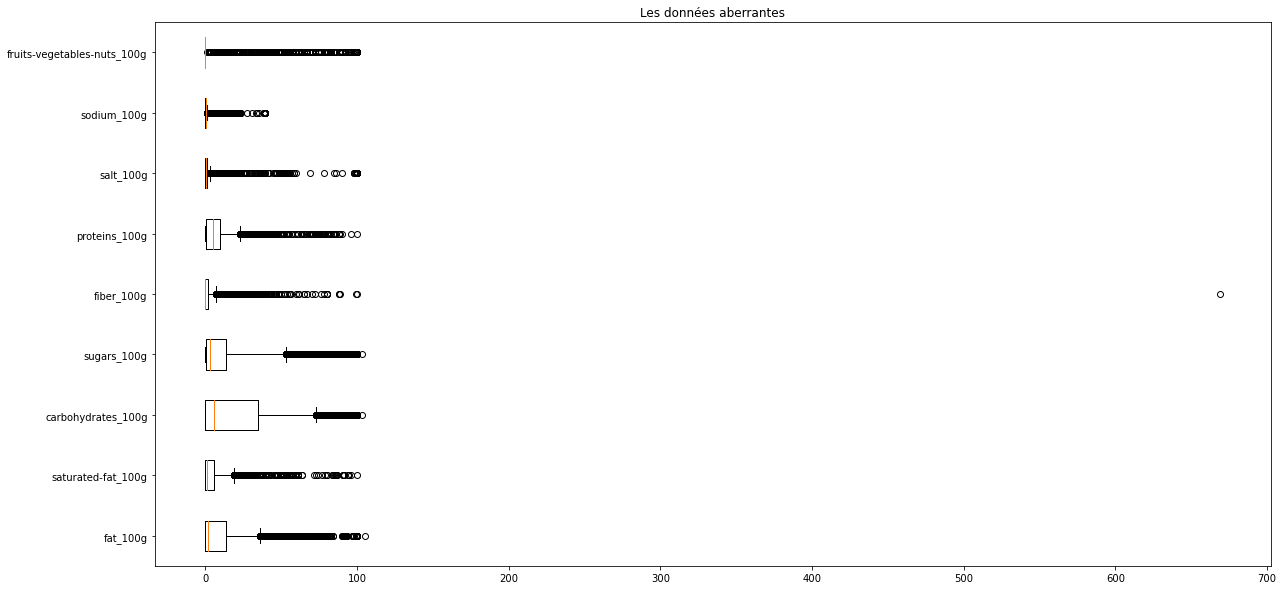

In [105]:
data = [ df_v2['fat_100g'], df_v2['saturated-fat_100g'],df_v2['carbohydrates_100g'],df_v2['sugars_100g'],df_v2['fiber_100g'],df_v2['proteins_100g'],df_v2['salt_100g'],df_v2['sodium_100g'],df_v2['fruits-vegetables-nuts_100g']]
plt.figure(figsize = (20,10))
ax = plt.boxplot(data, whis=[5,95], vert=False)


plt.title('Les données aberrantes')
plt.yticks([1, 2, 3,4,5,6,7,8,9], ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g' ])


plt.show()   

il s'agit de valeurs quantitatif pour 100g de produit ces valeurs ne peuvent donc ni etre négatives ni supérieures à 100

In [106]:
columns=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g']

for col in columns:
    df_v2.loc[df_v2[col]> 100, col] = 0
    

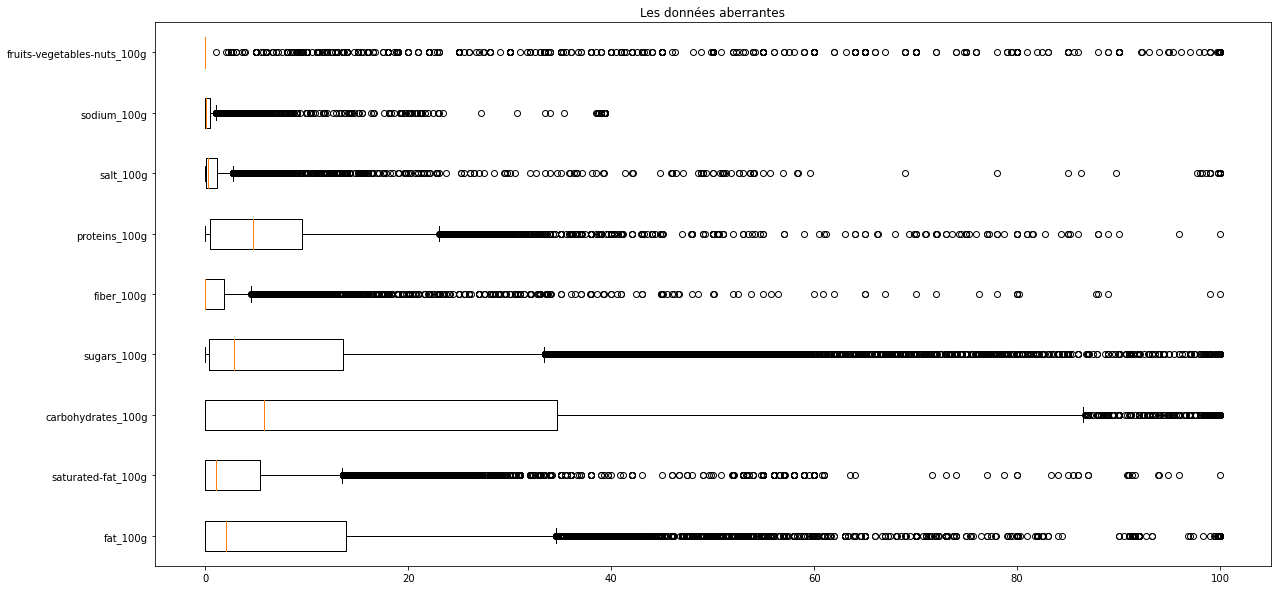

In [107]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(data, vert=False)


plt.title('Les données aberrantes')
plt.yticks([1, 2, 3,4,5,6,7,8,9], ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g' ])

plt.show()   

#### Traiter les valeurs impossibles

l'énergie d'un aliment ne peut pas être supérieure à 4000KJ (notion métier)

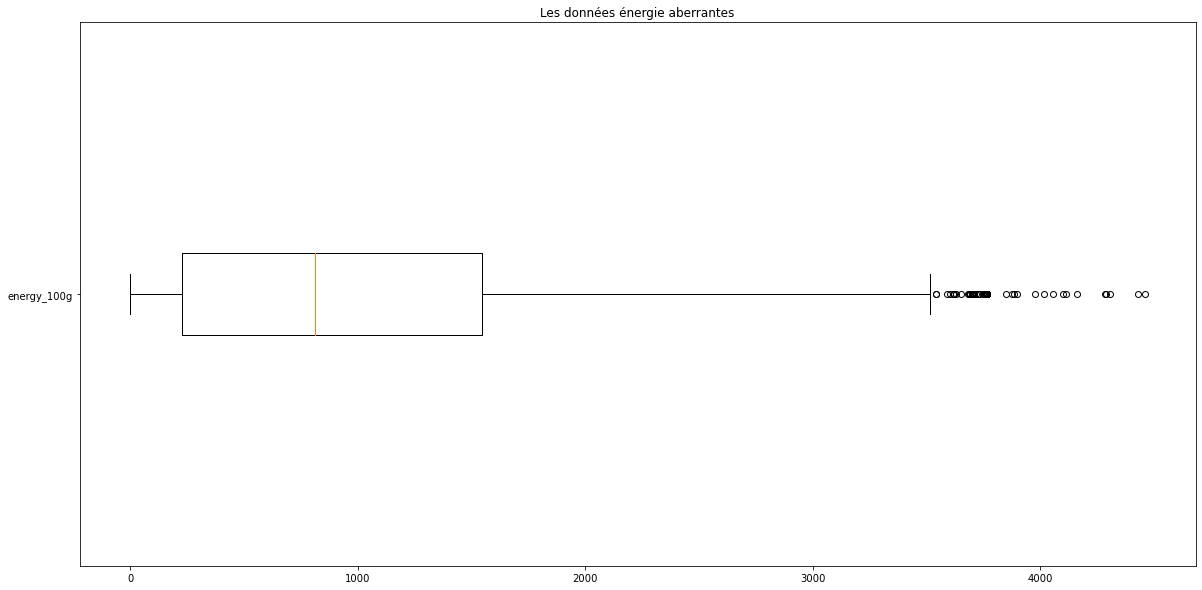

In [108]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(df_v2['energy_100g'], vert=False)

plt.title('Les données énergie aberrantes')
plt.yticks([1], ['energy_100g' ])

plt.show()   

In [55]:
df = df_[df_v2['energy_100g']<4000]

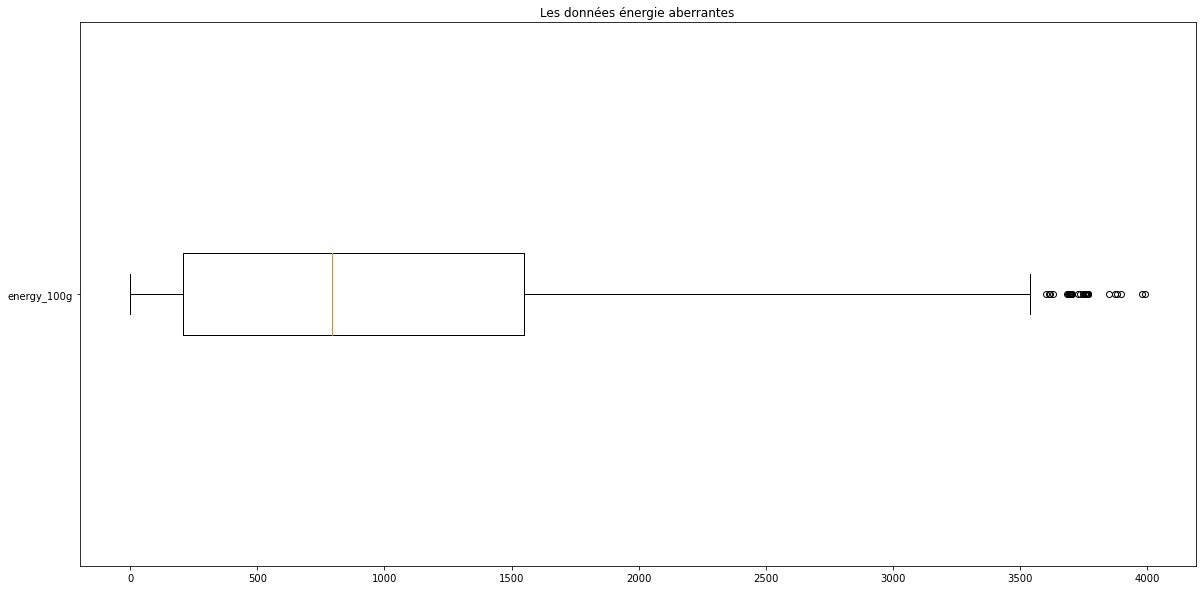

In [56]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(df['energy_100g'], vert=False)

plt.title('Les données énergie aberrantes')
plt.yticks([1], ['energy_100g' ])

plt.show()   

# sauvegarde du jeu de données nettoyées

In [57]:
df.to_csv("../data/02_intermediate/final.csv")